## CNN digit classifier (MNIST dataset) - Assignment-5
***Taha Adeel Mohammed - CS20BTECH11052***

### Importing the required libraries

In [2]:
# Import the modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm.notebook import tqdm

In [3]:
# Set the random seed for reproducibility
torch.manual_seed(37)
# plt.style.use('dark_background')

# Uses GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print('Using device:', device)

Using device: cuda:0


### Loading the dataset

In [4]:
# Download the data
train_data = MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = MNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor(),
)

# Print the dataset sizes
print(f'Train dataset size: {len(train_data)}')
print(f'Test dataset size: {len(test_data)}')

Train dataset size: 60000
Test dataset size: 10000


In [5]:
# Take 100 images per class for training
train_class_size = 100
train_indices = []
for i in range(10):
    train_indices.extend(np.where(train_data.targets == i)[0][:train_class_size])
train_data = Subset(train_data, train_indices)

# Take 10 images per class for testing
test_class_size = 10
test_indices = []
for i in range(10):
    test_indices.extend(np.where(test_data.targets == i)[0][:test_class_size])
test_data = Subset(test_data, test_indices)

# Print the dataset properties
print(f'Train dataset size: {len(train_data)}')
print(f'Test dataset size: {len(test_data)}')

Train dataset size: 1000
Test dataset size: 100


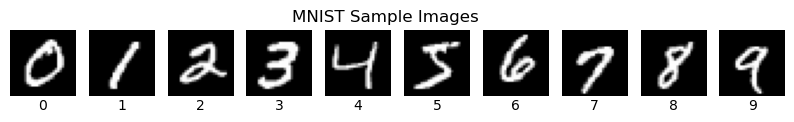

In [7]:
# Display sample images
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
fig.suptitle('MNIST Sample Images', y=1.03)
for i in range(10):
    axs[i].imshow(train_data[train_class_size*i][0].squeeze(), cmap='gray')
    axs[i].set_title(train_data[train_class_size*i][1], y=-0.33, fontsize=10)
    axs[i].axis('off')
plt.show()

### 1) CNN class

In [8]:
class CNN(nn.Module):
    ''' Vanilla CNN digit classifier
    
    Input(28x28) -> Conv(4, 5x5, 1) -> ReLU -> MaxPool(2x2, 2) -> Conv(4, 5x5x4, 1) -> ReLU -> MaxPool(2x2, 2) -> Flatten(4*7*7) -> MLP(49, 10) -> Softmax
    '''
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=4*7*7, out_features=49),
            nn.ReLU(),
            nn.Linear(in_features=49, out_features=10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.mlp(x)
        return x

##### 2) Train loop code for Q2

In [9]:
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device = torch.device('cpu'), verbose: bool = True):
    ''' Train the model for one epoch '''
    model.train() # Set model to training mode (Activates Dropout and BatchNorm)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # Move data to device(GPU if present)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss for 10 batches
        if verbose and batch % (max(len(dataloader)//10, 1)) == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'Loss: {loss:>7f} \t     [{current:>3d}/{size}]')

### 3) Epoch progress report functions

#### (a), (c) Training and test errors and accuracies

In [10]:
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, device: torch.device = torch.device('cpu')):
    ''' Computes and returns the error and accuracy on the given dataset.'''
    model.eval() # Set model to evaluation mode (Deactivates Dropout and BatchNorm)
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # Move data to device(GPU if present)
            
            # Compute prediction and loss
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            # Compute accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    avg_loss = test_loss / len(dataloader)
    accuracy = 100 * correct / len(dataloader.dataset)
    
    return avg_loss, accuracy

#### (b) Visualizing the activation maps

In [11]:
def visualize_activation_maps(model: CNN, dataloader: DataLoader, device: torch.device = torch.device('cpu')):
    ''' Visualize the activation maps at each of the convolutional layers of the model.'''
    model.eval() # Set model to evaluation mode
    
    # Get an input test image
    X, y = next(iter(dataloader))
    X = X[0].unsqueeze(0).to(device) # X.shape = (1, 1, 28, 28)
    img = X[0, 0].cpu().detach().numpy()
    
    # Get the activation volumes
    activations = []
    with torch.no_grad():
        for layer in model.conv_layers:
            X = layer(X)
            if isinstance(layer, nn.ReLU):
                activations.append(X)
    
    # Create the figure with subfigures
    fig = plt.figure(figsize=(10, 1))
    subfigs = fig.subfigures(1, 1+len(activations), wspace=0, width_ratios=[1, 4, 4])
    axs = subfigs[0].subplots(1, 1)
    subfigs[0].suptitle('Input Image', fontweight='bold', y=1.05)
    axs.imshow(img, cmap='gray')
    axs.set_title(f'Label: {y[0]}', y=-0.33, fontsize=10)
    axs.axis('off')
    
    # Plot the activation maps
    for i, activation in enumerate(activations):
        axs = subfigs[i+1].subplots(1, activation.shape[1])
        subfigs[i+1].suptitle(f'Activation maps at convolution layer {i+1}', fontweight='bold', y=1.05)
        for j in range(activation.shape[1]):
            axs[j].imshow(activation[0, j].cpu().detach().numpy())
            axs[j].set_title(f'Channel {j+1}', y=-0.33, fontsize=10)
            axs[j].axis('off')
    plt.show()

#### Training function

In [12]:
def fit(
    train_dataloader: DataLoader, 
    test_dataloader: DataLoader, 
    model: nn.Module, 
    loss_fn: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    epochs: int = 15, 
    device: torch.device = torch.device('cpu'), 
    verbose: int = 1, # 0 - No output, 1 - tqdm progress bar, 2 - Loss/Accuracy for each epoch, 3 - Activation maps for each epoch, 4 - Batch-wise loss
    plot_errors: bool = False
):
    ''' Trains the model for the given number of epochs and reports the progress after each epoch.'''
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    for epoch in tqdm(range(epochs), disable=(verbose == 0), desc='Epochs'):
        if verbose > 2: print('\n-------------------------------')
        if verbose > 1: print(f'Epoch {epoch+1:2d}', end=' ')
        if verbose > 2: print('\n-------------------------------')
        
        # Train the model for one epoch
        train_loop(train_dataloader, model, loss_fn, optimizer, device, verbose > 3)
        
        # 3a. Get the train and test error and accuracy
        train_loss, train_accuracy = test_loop(train_dataloader, model, loss_fn, device)
        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        
        # Store the train and test error and accuracy
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
            
        # 3b. Visualize the activation maps
        if verbose > 2:
            visualize_activation_maps(model, test_dataloader, device)
        
        # 3c. Report the accuracy of the classifier
        if verbose > 1:
            print(f'-> Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Train Accuracy: {train_accuracy:.1f}% | Test Accuracy: {test_accuracy:.1f}%')
        
    
    # 3a. Plot the train and test errors
    if plot_errors:
        fig, axs = plt.subplots(1, 2, figsize=(10, 2.8))
        fig.suptitle(f'Train & Test Errors/Accuracies vs Epochs: {optimizer.__class__.__name__} Optimizer', fontweight='bold')
        axs[0].plot(np.arange(1, epoch+2), train_losses, label='Train')
        axs[0].plot(np.arange(1, epoch+2), test_losses, label='Test')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].xaxis.set_ticks(np.arange(1, epoch+2))
        axs[0].legend()
        axs[1].plot(np.arange(1, epoch+2), train_accuracies, label='Train')
        axs[1].plot(np.arange(1, epoch+2), test_accuracies, label='Test')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].xaxis.set_ticks(np.arange(1, epoch+2))
        axs[1].legend()
        plt.show()
    
    return test_accuracies[-1]

### 2) Training the model with different optimizers

In [13]:
# Training parameters
batch_size = 10 # Final batch size we use for 3 a,b,c
shuffle = True
num_epochs = 15
loss_fn = nn.CrossEntropyLoss() # Note that nn.CrossEntropyLoss() internally accounts for the ground truth label one-hot encoding, hence we do not explicitly do the one-hot encoding on our dataset labels

In [14]:
# Create the dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)

#### Experimenting with different batch sizes for SGD

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

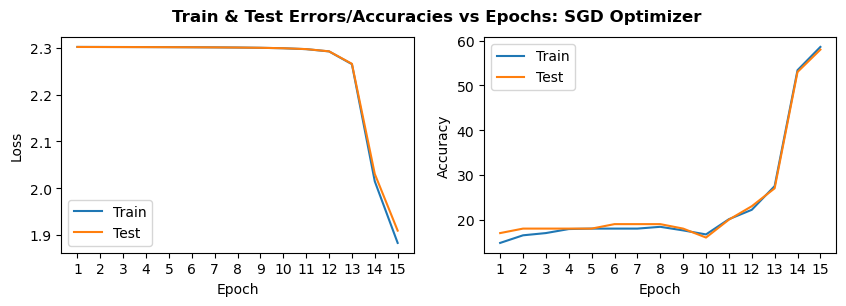

Training with batch size 1 took 48.35 seconds and achieved a final accuracy of 58.0% after 15 epochs.


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

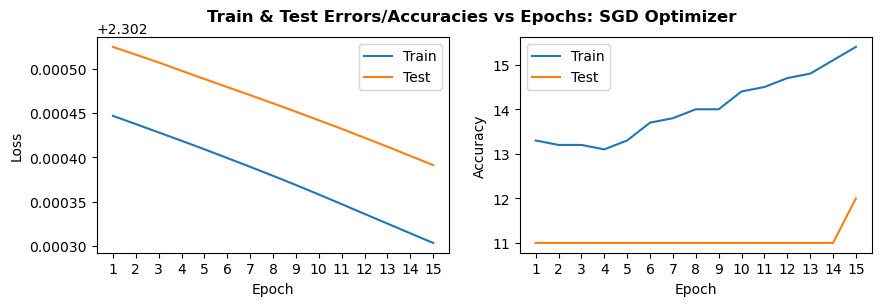

Training with batch size 10 took 7.09 seconds and achieved a final accuracy of 12.0% after 15 epochs.


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

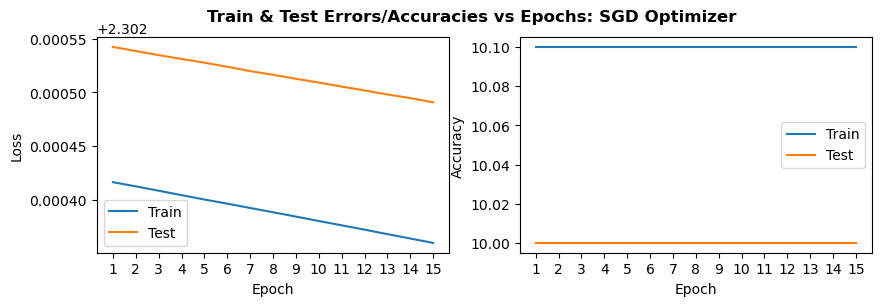

Training with batch size 50 took 3.46 seconds and achieved a final accuracy of 10.0% after 15 epochs.


In [15]:
# Experimenting with SGD batch sizes
import time

test_batch_sizes = [1, 10, 50] # Experimenting with SGD batch sizes -> Observation: Small batch size converges in lesser epochs, but each epoch takes much longer to train

for test_batch_size in test_batch_sizes:
    test_train_dataloader = DataLoader(train_data, batch_size=test_batch_size, shuffle=shuffle)
    test_test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=shuffle)
    
    model = CNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005) # Note that we are using a higher learning rate than 0.001

    start_time = time.time()
    final_accuracy = fit(test_train_dataloader, test_test_dataloader, model, loss_fn, optimizer, num_epochs, device, 1, True)
    end_time = time.time()

    print(f'Training with batch size {test_batch_size} took {end_time - start_time:.2f} seconds and achieved a final accuracy of {final_accuracy:.1f}% after {num_epochs} epochs.')

Hence we see that smaller batch sizes converges in lesser epochs, but each epoch takes much longer to train, and the noise/standard deviation in the loss is higher for smaller batch sizes. Hence we choose a batch size of 10 for the rest of the experiments as it is a good tradeoff between the number of epochs and the time taken to train each epoch.

#### (a) Vanilla SGD

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


-------------------------------
Epoch  1 
-------------------------------


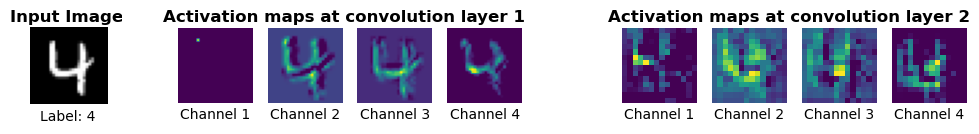

-> Train Loss: 2.302746 | Test Loss: 2.302743 | Train Accuracy: 12.3% | Test Accuracy: 13.0%

-------------------------------
Epoch  2 
-------------------------------


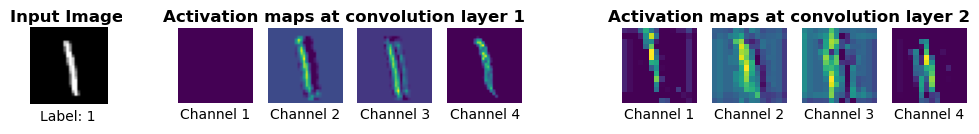

-> Train Loss: 2.302741 | Test Loss: 2.302737 | Train Accuracy: 12.3% | Test Accuracy: 13.0%

-------------------------------
Epoch  3 
-------------------------------


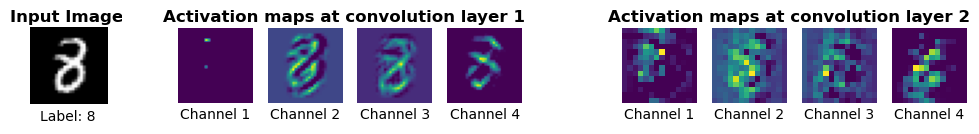

-> Train Loss: 2.302735 | Test Loss: 2.302731 | Train Accuracy: 12.3% | Test Accuracy: 13.0%

-------------------------------
Epoch  4 
-------------------------------


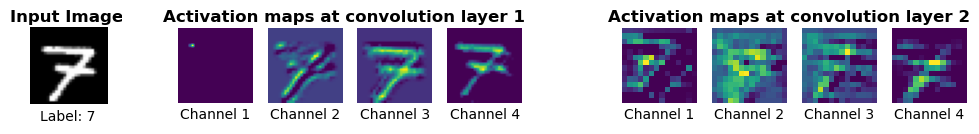

-> Train Loss: 2.302729 | Test Loss: 2.302725 | Train Accuracy: 12.3% | Test Accuracy: 13.0%

-------------------------------
Epoch  5 
-------------------------------


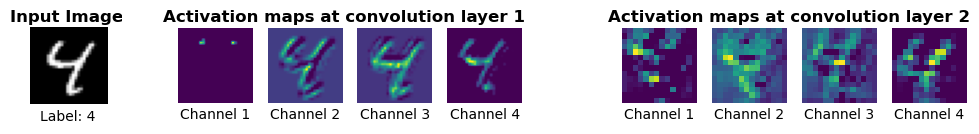

-> Train Loss: 2.302724 | Test Loss: 2.302719 | Train Accuracy: 12.3% | Test Accuracy: 13.0%

-------------------------------
Epoch  6 
-------------------------------


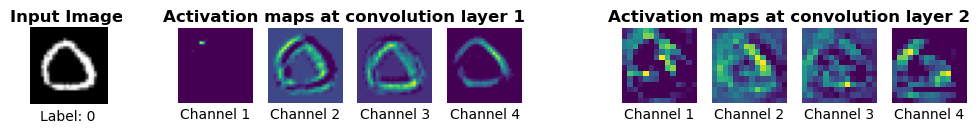

-> Train Loss: 2.302718 | Test Loss: 2.302713 | Train Accuracy: 12.3% | Test Accuracy: 13.0%

-------------------------------
Epoch  7 
-------------------------------


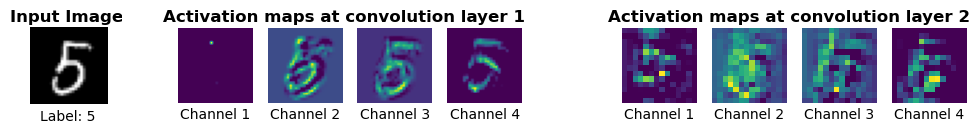

-> Train Loss: 2.302712 | Test Loss: 2.302707 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch  8 
-------------------------------


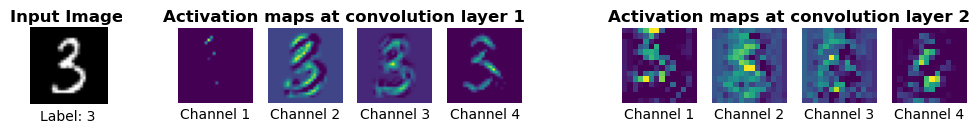

-> Train Loss: 2.302707 | Test Loss: 2.302701 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch  9 
-------------------------------


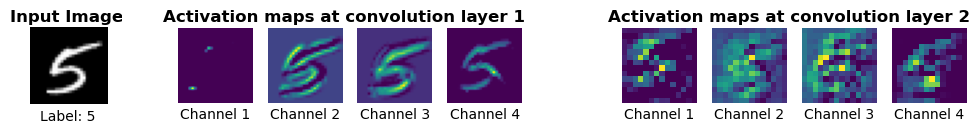

-> Train Loss: 2.302701 | Test Loss: 2.302695 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch 10 
-------------------------------


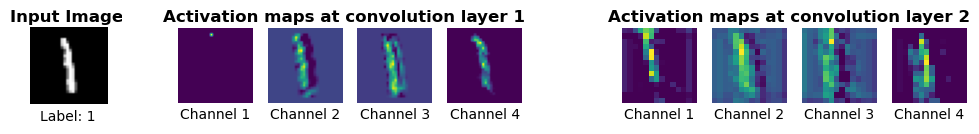

-> Train Loss: 2.302695 | Test Loss: 2.302689 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch 11 
-------------------------------


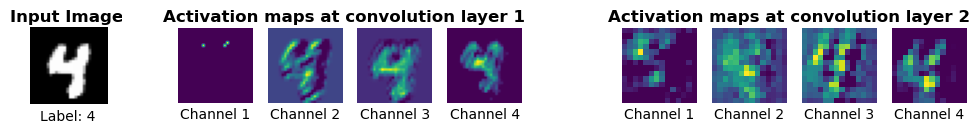

-> Train Loss: 2.302689 | Test Loss: 2.302684 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch 12 
-------------------------------


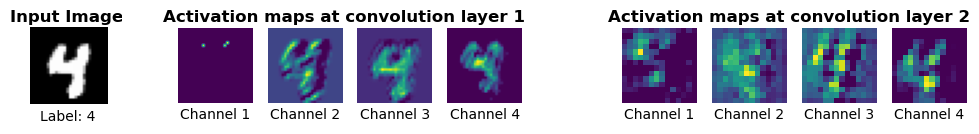

-> Train Loss: 2.302684 | Test Loss: 2.302678 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch 13 
-------------------------------


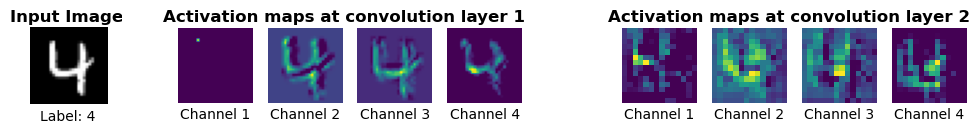

-> Train Loss: 2.302678 | Test Loss: 2.302672 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch 14 
-------------------------------


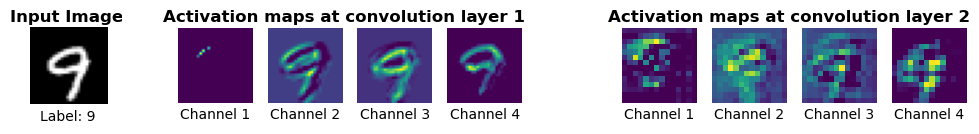

-> Train Loss: 2.302672 | Test Loss: 2.302666 | Train Accuracy: 12.4% | Test Accuracy: 13.0%

-------------------------------
Epoch 15 
-------------------------------


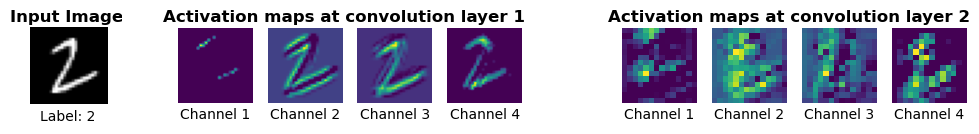

-> Train Loss: 2.302667 | Test Loss: 2.302660 | Train Accuracy: 12.4% | Test Accuracy: 13.0%


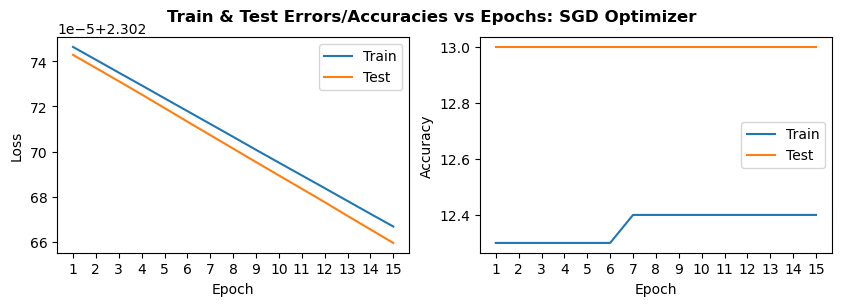

In [16]:
sgd_model = CNN().to(device)
sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=0.001)

final_accuracy = fit(train_dataloader, test_dataloader, sgd_model, loss_fn, sgd_optimizer, num_epochs, device, verbose=3, plot_errors=True)

#### (b) SGD with momentum

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


-------------------------------
Epoch  1 
-------------------------------


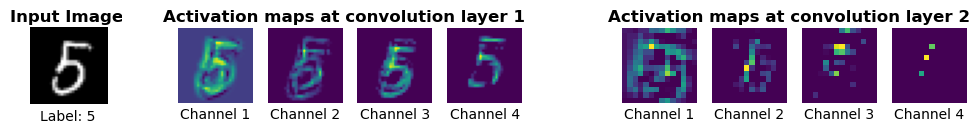

-> Train Loss: 2.302596 | Test Loss: 2.302496 | Train Accuracy: 6.1% | Test Accuracy: 8.0%

-------------------------------
Epoch  2 
-------------------------------


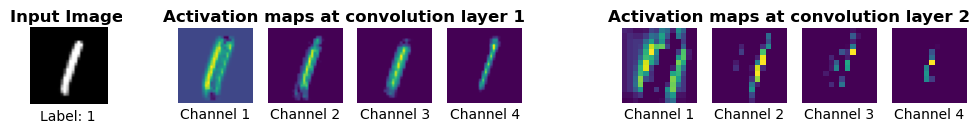

-> Train Loss: 2.302557 | Test Loss: 2.302470 | Train Accuracy: 6.5% | Test Accuracy: 8.0%

-------------------------------
Epoch  3 
-------------------------------


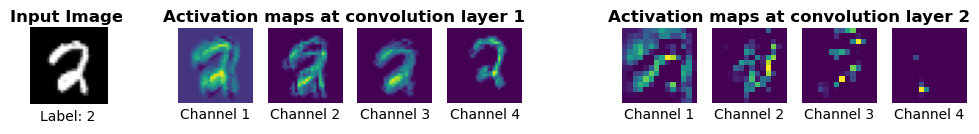

-> Train Loss: 2.302522 | Test Loss: 2.302443 | Train Accuracy: 7.0% | Test Accuracy: 8.0%

-------------------------------
Epoch  4 
-------------------------------


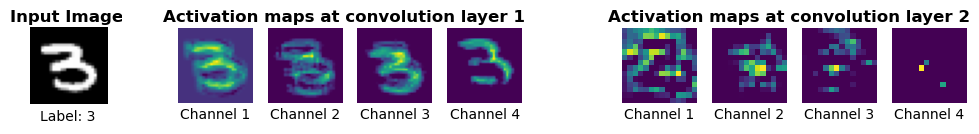

-> Train Loss: 2.302489 | Test Loss: 2.302416 | Train Accuracy: 7.7% | Test Accuracy: 8.0%

-------------------------------
Epoch  5 
-------------------------------


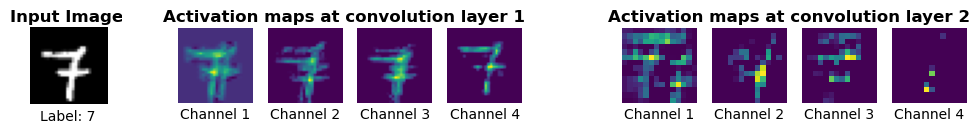

-> Train Loss: 2.302458 | Test Loss: 2.302390 | Train Accuracy: 8.2% | Test Accuracy: 9.0%

-------------------------------
Epoch  6 
-------------------------------


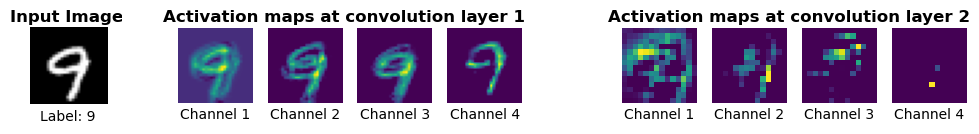

-> Train Loss: 2.302428 | Test Loss: 2.302365 | Train Accuracy: 8.3% | Test Accuracy: 9.0%

-------------------------------
Epoch  7 
-------------------------------


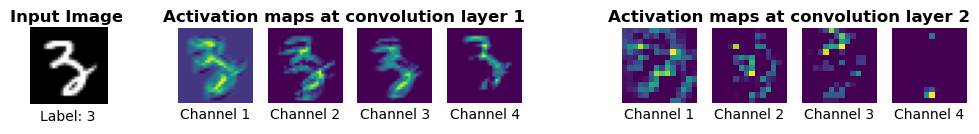

-> Train Loss: 2.302399 | Test Loss: 2.302340 | Train Accuracy: 8.8% | Test Accuracy: 9.0%

-------------------------------
Epoch  8 
-------------------------------


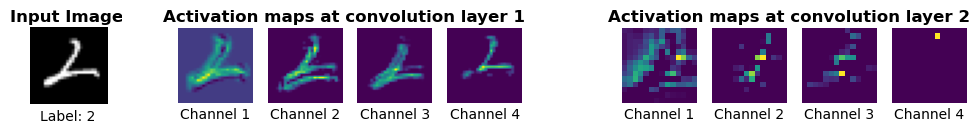

-> Train Loss: 2.302370 | Test Loss: 2.302315 | Train Accuracy: 9.3% | Test Accuracy: 11.0%

-------------------------------
Epoch  9 
-------------------------------


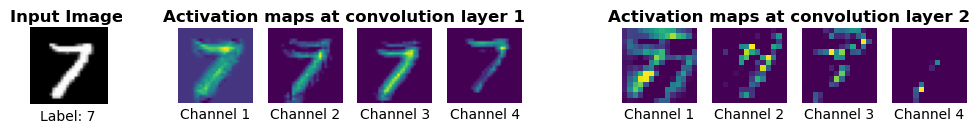

-> Train Loss: 2.302341 | Test Loss: 2.302289 | Train Accuracy: 9.9% | Test Accuracy: 12.0%

-------------------------------
Epoch 10 
-------------------------------


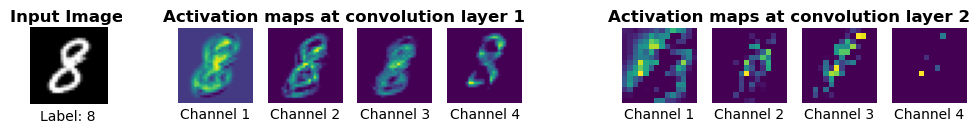

-> Train Loss: 2.302310 | Test Loss: 2.302261 | Train Accuracy: 10.0% | Test Accuracy: 11.0%

-------------------------------
Epoch 11 
-------------------------------


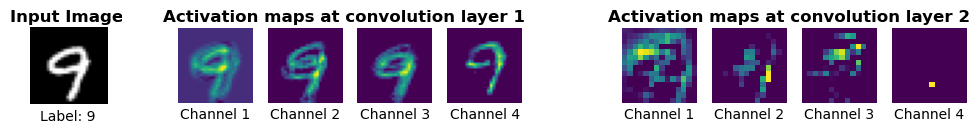

-> Train Loss: 2.302281 | Test Loss: 2.302234 | Train Accuracy: 10.0% | Test Accuracy: 12.0%

-------------------------------
Epoch 12 
-------------------------------


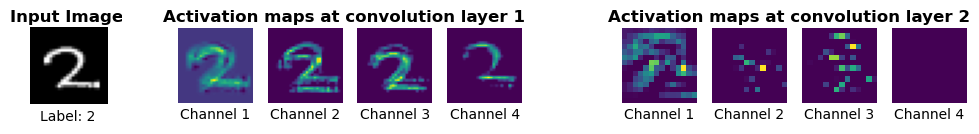

-> Train Loss: 2.302251 | Test Loss: 2.302206 | Train Accuracy: 10.6% | Test Accuracy: 12.0%

-------------------------------
Epoch 13 
-------------------------------


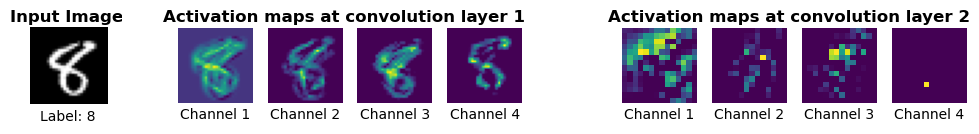

-> Train Loss: 2.302220 | Test Loss: 2.302177 | Train Accuracy: 11.2% | Test Accuracy: 12.0%

-------------------------------
Epoch 14 
-------------------------------


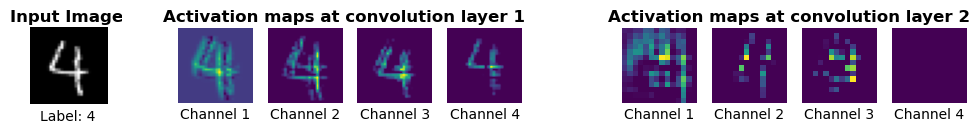

-> Train Loss: 2.302189 | Test Loss: 2.302148 | Train Accuracy: 11.5% | Test Accuracy: 12.0%

-------------------------------
Epoch 15 
-------------------------------


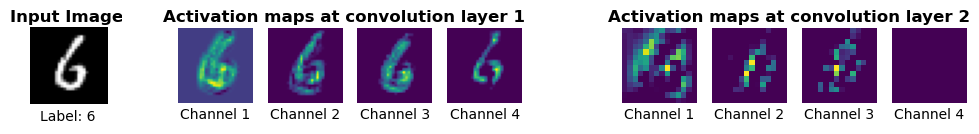

-> Train Loss: 2.302156 | Test Loss: 2.302117 | Train Accuracy: 12.3% | Test Accuracy: 14.0%


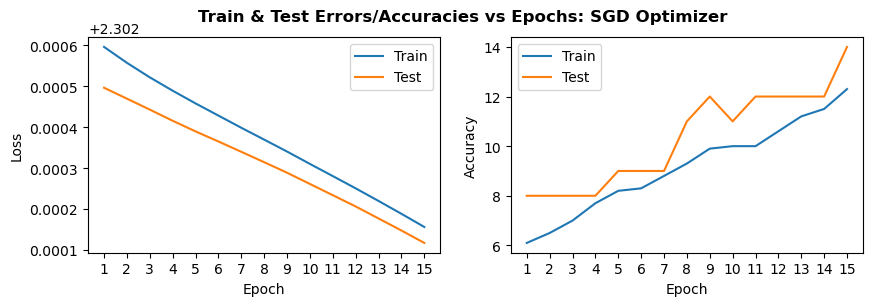

In [17]:
momentum_model = CNN().to(device)
momentum_optimizer = torch.optim.SGD(momentum_model.parameters(), lr=0.001, momentum=0.9)

final_accuracy = fit(train_dataloader, test_dataloader, momentum_model, loss_fn, momentum_optimizer, num_epochs, device, verbose=3, plot_errors=True)

#### (c) RMSProp

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


-------------------------------
Epoch  1 
-------------------------------
Loss: 2.303750 	     [  0/1000]
Loss: 2.302572 	     [100/1000]
Loss: 2.299931 	     [200/1000]
Loss: 2.297637 	     [300/1000]
Loss: 2.296197 	     [400/1000]
Loss: 2.298189 	     [500/1000]
Loss: 2.278870 	     [600/1000]
Loss: 2.125086 	     [700/1000]
Loss: 2.294221 	     [800/1000]
Loss: 2.124700 	     [900/1000]


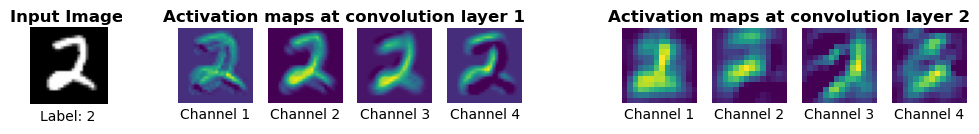

-> Train Loss: 2.148358 | Test Loss: 2.157359 | Train Accuracy: 37.5% | Test Accuracy: 40.0%

-------------------------------
Epoch  2 
-------------------------------
Loss: 2.228987 	     [  0/1000]
Loss: 2.143579 	     [100/1000]
Loss: 2.257123 	     [200/1000]
Loss: 2.131096 	     [300/1000]
Loss: 2.105383 	     [400/1000]
Loss: 2.011120 	     [500/1000]
Loss: 1.836658 	     [600/1000]
Loss: 2.027992 	     [700/1000]
Loss: 1.911525 	     [800/1000]
Loss: 1.802007 	     [900/1000]


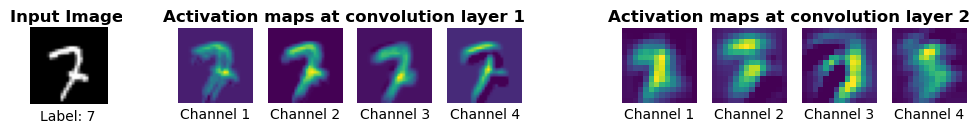

-> Train Loss: 1.824867 | Test Loss: 1.871733 | Train Accuracy: 69.9% | Test Accuracy: 65.0%

-------------------------------
Epoch  3 
-------------------------------
Loss: 1.865165 	     [  0/1000]
Loss: 1.770536 	     [100/1000]
Loss: 1.883054 	     [200/1000]
Loss: 1.668113 	     [300/1000]
Loss: 1.630536 	     [400/1000]
Loss: 1.845119 	     [500/1000]
Loss: 1.818935 	     [600/1000]
Loss: 1.916699 	     [700/1000]
Loss: 1.595371 	     [800/1000]
Loss: 1.633282 	     [900/1000]


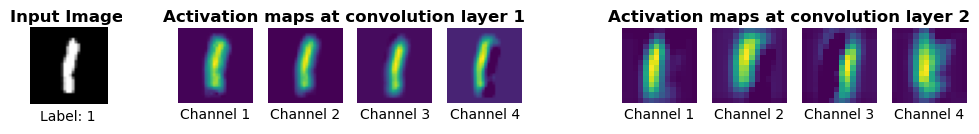

-> Train Loss: 1.737944 | Test Loss: 1.760998 | Train Accuracy: 74.8% | Test Accuracy: 74.0%

-------------------------------
Epoch  4 
-------------------------------
Loss: 1.653484 	     [  0/1000]
Loss: 1.708033 	     [100/1000]
Loss: 2.055334 	     [200/1000]
Loss: 1.591620 	     [300/1000]
Loss: 1.733802 	     [400/1000]
Loss: 1.815057 	     [500/1000]
Loss: 1.733041 	     [600/1000]
Loss: 1.667740 	     [700/1000]
Loss: 1.750534 	     [800/1000]
Loss: 1.761856 	     [900/1000]


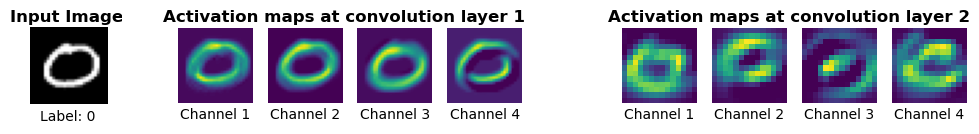

-> Train Loss: 1.662158 | Test Loss: 1.696783 | Train Accuracy: 82.6% | Test Accuracy: 80.0%

-------------------------------
Epoch  5 
-------------------------------
Loss: 1.707913 	     [  0/1000]
Loss: 1.772226 	     [100/1000]
Loss: 1.630301 	     [200/1000]
Loss: 1.520808 	     [300/1000]
Loss: 1.859231 	     [400/1000]
Loss: 1.666293 	     [500/1000]
Loss: 1.595639 	     [600/1000]
Loss: 1.794912 	     [700/1000]
Loss: 1.577259 	     [800/1000]
Loss: 1.490098 	     [900/1000]


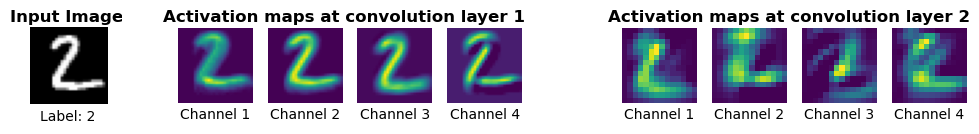

-> Train Loss: 1.653155 | Test Loss: 1.675594 | Train Accuracy: 81.4% | Test Accuracy: 81.0%

-------------------------------
Epoch  6 
-------------------------------
Loss: 1.549842 	     [  0/1000]
Loss: 1.652516 	     [100/1000]
Loss: 1.522744 	     [200/1000]
Loss: 1.589341 	     [300/1000]
Loss: 1.536420 	     [400/1000]
Loss: 1.655396 	     [500/1000]
Loss: 1.474618 	     [600/1000]
Loss: 1.590744 	     [700/1000]
Loss: 1.600513 	     [800/1000]
Loss: 1.614819 	     [900/1000]


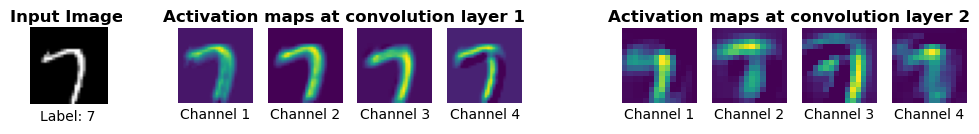

-> Train Loss: 1.625236 | Test Loss: 1.696626 | Train Accuracy: 84.9% | Test Accuracy: 78.0%

-------------------------------
Epoch  7 
-------------------------------
Loss: 1.574134 	     [  0/1000]
Loss: 1.522508 	     [100/1000]
Loss: 1.487647 	     [200/1000]
Loss: 1.508428 	     [300/1000]
Loss: 1.684586 	     [400/1000]
Loss: 1.543733 	     [500/1000]
Loss: 1.782550 	     [600/1000]
Loss: 1.592028 	     [700/1000]
Loss: 1.657364 	     [800/1000]
Loss: 1.695709 	     [900/1000]


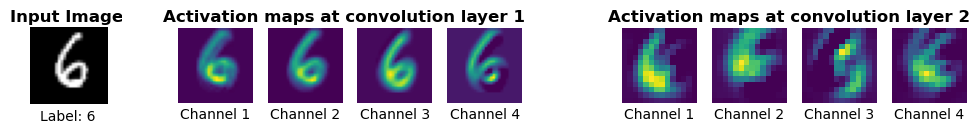

-> Train Loss: 1.593539 | Test Loss: 1.630746 | Train Accuracy: 88.1% | Test Accuracy: 84.0%

-------------------------------
Epoch  8 
-------------------------------
Loss: 1.576293 	     [  0/1000]
Loss: 1.598849 	     [100/1000]
Loss: 1.467156 	     [200/1000]
Loss: 1.657169 	     [300/1000]
Loss: 1.620825 	     [400/1000]
Loss: 1.656361 	     [500/1000]
Loss: 1.518198 	     [600/1000]
Loss: 1.588942 	     [700/1000]
Loss: 1.560035 	     [800/1000]
Loss: 1.504971 	     [900/1000]


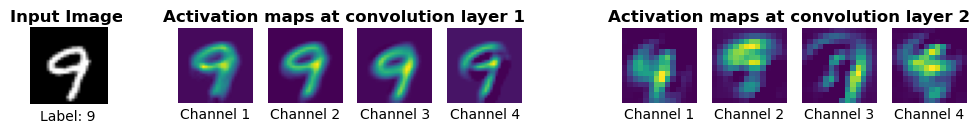

-> Train Loss: 1.582564 | Test Loss: 1.628901 | Train Accuracy: 88.7% | Test Accuracy: 85.0%

-------------------------------
Epoch  9 
-------------------------------
Loss: 1.466370 	     [  0/1000]
Loss: 1.755252 	     [100/1000]
Loss: 1.479148 	     [200/1000]
Loss: 1.623559 	     [300/1000]
Loss: 1.621119 	     [400/1000]
Loss: 1.703480 	     [500/1000]
Loss: 1.567761 	     [600/1000]
Loss: 1.562870 	     [700/1000]
Loss: 1.761322 	     [800/1000]
Loss: 1.560771 	     [900/1000]


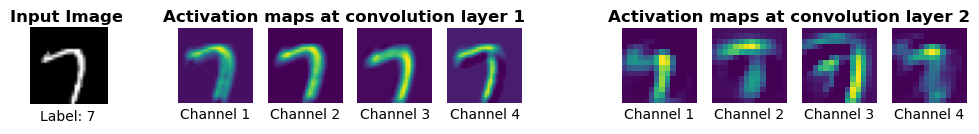

-> Train Loss: 1.574597 | Test Loss: 1.591292 | Train Accuracy: 89.2% | Test Accuracy: 88.0%

-------------------------------
Epoch 10 
-------------------------------
Loss: 1.505756 	     [  0/1000]
Loss: 1.519264 	     [100/1000]
Loss: 1.682983 	     [200/1000]
Loss: 1.478063 	     [300/1000]
Loss: 1.795831 	     [400/1000]
Loss: 1.518095 	     [500/1000]
Loss: 1.562396 	     [600/1000]
Loss: 1.599841 	     [700/1000]
Loss: 1.466555 	     [800/1000]
Loss: 1.501667 	     [900/1000]


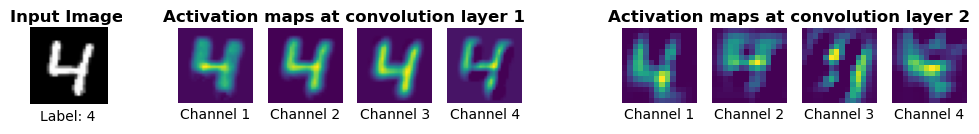

-> Train Loss: 1.547756 | Test Loss: 1.582863 | Train Accuracy: 92.0% | Test Accuracy: 89.0%

-------------------------------
Epoch 11 
-------------------------------
Loss: 1.485478 	     [  0/1000]
Loss: 1.485453 	     [100/1000]
Loss: 1.704110 	     [200/1000]
Loss: 1.478339 	     [300/1000]
Loss: 1.643626 	     [400/1000]
Loss: 1.520172 	     [500/1000]
Loss: 1.657590 	     [600/1000]
Loss: 1.540170 	     [700/1000]
Loss: 1.681716 	     [800/1000]
Loss: 1.573796 	     [900/1000]


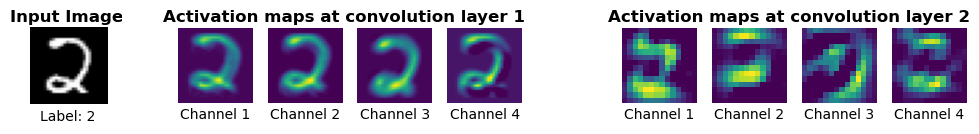

-> Train Loss: 1.559062 | Test Loss: 1.593687 | Train Accuracy: 90.8% | Test Accuracy: 87.0%

-------------------------------
Epoch 12 
-------------------------------
Loss: 1.481217 	     [  0/1000]
Loss: 1.563382 	     [100/1000]
Loss: 1.507626 	     [200/1000]
Loss: 1.643787 	     [300/1000]
Loss: 1.540896 	     [400/1000]
Loss: 1.466375 	     [500/1000]
Loss: 1.571136 	     [600/1000]
Loss: 1.659922 	     [700/1000]
Loss: 1.637750 	     [800/1000]
Loss: 1.569025 	     [900/1000]


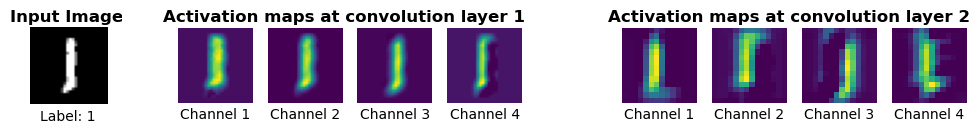

-> Train Loss: 1.536499 | Test Loss: 1.588397 | Train Accuracy: 93.2% | Test Accuracy: 88.0%

-------------------------------
Epoch 13 
-------------------------------
Loss: 1.560984 	     [  0/1000]
Loss: 1.526823 	     [100/1000]
Loss: 1.461820 	     [200/1000]
Loss: 1.562189 	     [300/1000]
Loss: 1.571139 	     [400/1000]
Loss: 1.470223 	     [500/1000]
Loss: 1.583606 	     [600/1000]
Loss: 1.614152 	     [700/1000]
Loss: 1.509328 	     [800/1000]
Loss: 1.661937 	     [900/1000]


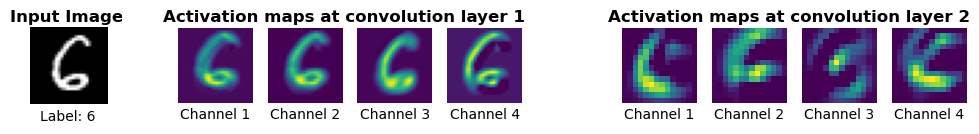

-> Train Loss: 1.537314 | Test Loss: 1.577661 | Train Accuracy: 92.8% | Test Accuracy: 89.0%

-------------------------------
Epoch 14 
-------------------------------
Loss: 1.563186 	     [  0/1000]
Loss: 1.561611 	     [100/1000]
Loss: 1.482734 	     [200/1000]
Loss: 1.539888 	     [300/1000]
Loss: 1.659356 	     [400/1000]
Loss: 1.462902 	     [500/1000]
Loss: 1.618137 	     [600/1000]
Loss: 1.481555 	     [700/1000]
Loss: 1.565354 	     [800/1000]
Loss: 1.533723 	     [900/1000]


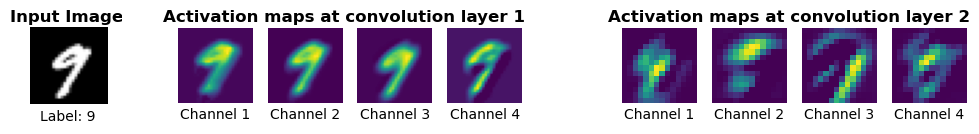

-> Train Loss: 1.568095 | Test Loss: 1.607857 | Train Accuracy: 90.0% | Test Accuracy: 86.0%

-------------------------------
Epoch 15 
-------------------------------
Loss: 1.684076 	     [  0/1000]
Loss: 1.568810 	     [100/1000]
Loss: 1.462398 	     [200/1000]
Loss: 1.462742 	     [300/1000]
Loss: 1.609378 	     [400/1000]
Loss: 1.498207 	     [500/1000]
Loss: 1.658049 	     [600/1000]
Loss: 1.641696 	     [700/1000]
Loss: 1.462852 	     [800/1000]
Loss: 1.563679 	     [900/1000]


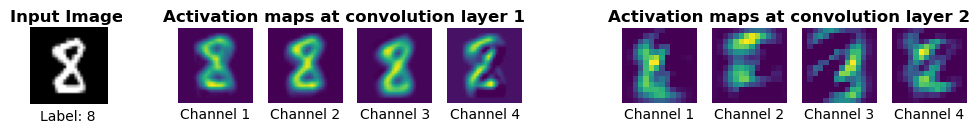

-> Train Loss: 1.521690 | Test Loss: 1.570328 | Train Accuracy: 94.7% | Test Accuracy: 90.0%


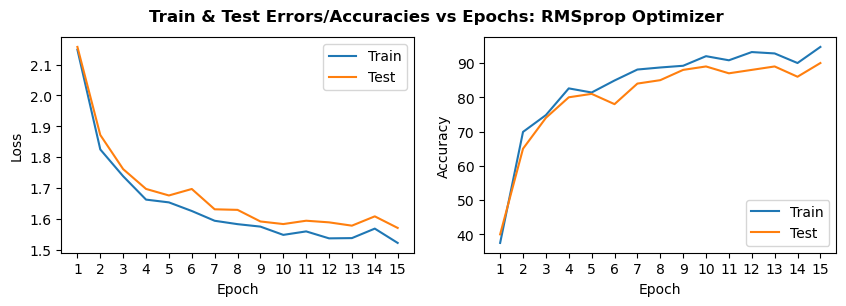

In [18]:
# RMSProp. Use η = 0.001, ρ = 0.9.
rmsprop_model = CNN().to(device)
rmsprop_optimizer = torch.optim.RMSprop(rmsprop_model.parameters(), lr=0.001, alpha=0.9)

final_accuracy = fit(train_dataloader, test_dataloader, rmsprop_model, loss_fn, rmsprop_optimizer, num_epochs, device, verbose=4, plot_errors=True) # Change verbose to 3 to not print the batch-wise loss

So we observe that just vanilla SGD takes very long to converge, while momentum is better, and RMSProp converges very quickly, performing better than momentum in a single epoch.

### 4) tSNE

The bottleneck feature is a neural network is simply a layer which has fewer nodes than previous layers. Here, we consider the output of the second max pooling layer as the bottelneck feature, which is then flattened and fed to the MLP. We get this output and visualize it using tSNE. We use the same model as in Q2(c) with RMSProp optimizer.

In [19]:
# Get the bottleneck features and labels
tsne_model = CNN().to(device)
optimizer = torch.optim.RMSprop(tsne_model.parameters(), lr=0.001, alpha=0.9)

# fit(train_dataloader, None, tsne_model, loss_fn, optimizer, epochs=1, device=device, verbose=0, plot_errors=False) # Uncomment to run the model for 1 epoch, after which accuracy is already >50%. Hence to showcase the earlier embedding vs later embedding, I have used the model before training

# Get the initial bottleneck features
bottleneck_i = []
labels_i = []
tsne_model.eval()
with torch.no_grad():
    for X, y in train_dataloader:
        X = X.to(device)
        bottleneck_i.append(tsne_model.conv_layers(X).cpu().detach().numpy())
        labels_i.append(y.numpy())
bottleneck_i = np.concatenate(bottleneck_i) # bottleneck_features.shape = (1000, 4, 7, 7)
labels_i = np.concatenate(labels_i) # labels.shape = (1000,)

# Train the model
final_accuracy = fit(train_dataloader, test_dataloader, tsne_model, loss_fn, optimizer, epochs=15, device=device, verbose=2, plot_errors=False)

# Get the final bottleneck features
bottleneck_f = []
labels_f = []
tsne_model.eval()
with torch.no_grad():
    for X, y in train_dataloader:
        X = X.to(device)
        bottleneck_f.append(tsne_model.conv_layers(X).cpu().detach().numpy())
        labels_f.append(y.numpy())
bottleneck_f = np.concatenate(bottleneck_f) # bottleneck_features.shape = (1000, 4, 7, 7)
labels_f = np.concatenate(labels_f) # labels.shape = (1000,)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  1 -> Train Loss: 1.977455 | Test Loss: 1.988577 | Train Accuracy: 63.1% | Test Accuracy: 58.0%
Epoch  2 -> Train Loss: 1.743123 | Test Loss: 1.752999 | Train Accuracy: 75.0% | Test Accuracy: 77.0%
Epoch  3 -> Train Loss: 1.693543 | Test Loss: 1.692480 | Train Accuracy: 78.5% | Test Accuracy: 79.0%
Epoch  4 -> Train Loss: 1.637659 | Test Loss: 1.643528 | Train Accuracy: 84.3% | Test Accuracy: 85.0%
Epoch  5 -> Train Loss: 1.631113 | Test Loss: 1.682684 | Train Accuracy: 84.0% | Test Accuracy: 79.0%
Epoch  6 -> Train Loss: 1.598544 | Test Loss: 1.619401 | Train Accuracy: 87.3% | Test Accuracy: 86.0%
Epoch  7 -> Train Loss: 1.616717 | Test Loss: 1.666275 | Train Accuracy: 84.9% | Test Accuracy: 80.0%
Epoch  8 -> Train Loss: 1.575986 | Test Loss: 1.640983 | Train Accuracy: 89.6% | Test Accuracy: 83.0%
Epoch  9 -> Train Loss: 1.576294 | Test Loss: 1.595679 | Train Accuracy: 89.0% | Test Accuracy: 86.0%
Epoch 10 -> Train Loss: 1.545645 | Test Loss: 1.570177 | Train Accuracy: 93.2% | T

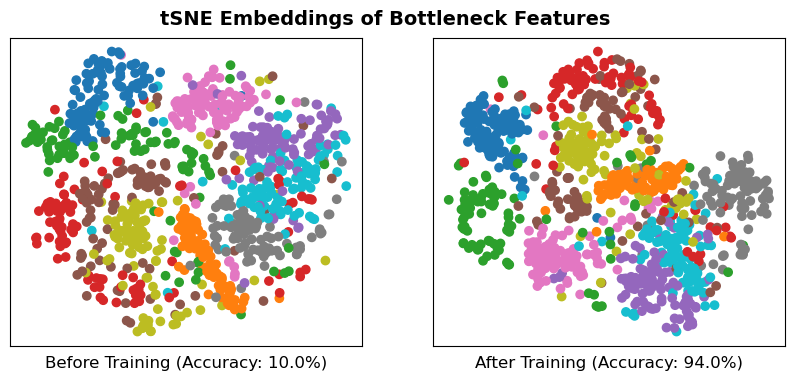

In [20]:
# Visualize the bottleneck features using tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=150, random_state=0)

# Get the embeddings from the bottleneck features
bottleneck_i_embedded = tsne.fit_transform(bottleneck_i.reshape(bottleneck_i.shape[0], -1))
bottleneck_f_embedded = tsne.fit_transform(bottleneck_f.reshape(bottleneck_f.shape[0], -1))

# Plot the embeddings
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('tSNE Embeddings of Bottleneck Features', fontweight='bold', fontsize=14, y=0.95)

axs[0].scatter(bottleneck_i_embedded[:, 0], bottleneck_i_embedded[:, 1], c=labels_i, cmap='tab10')
axs[0].set_title(f'Before Training (Accuracy: 10.0%)', y=-0.1)
axs[0].set_xticks([])
axs[0].set_yticks([])


axs[1].scatter(bottleneck_f_embedded[:, 0], bottleneck_f_embedded[:, 1], c=labels_f, cmap='tab10')
axs[1].set_title(f'After Training (Accuracy: {final_accuracy:0.1f}%)', y=-0.1)
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.show()

Hence we can see that even before training, there is some clustering at the output of the convolutional layers. After training, the clusters are more defined, and the clusters are more separated. This shows that the CNN is able to learn features which are useful for classification.

### 5) Using Dropout

--------------------------------------
Running model with dropout rate 0.2...


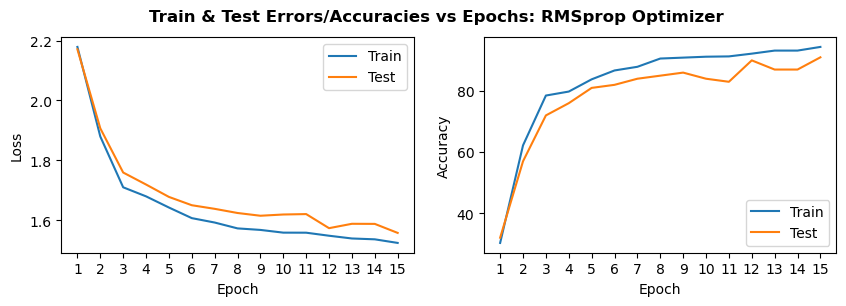

Final testing accuracy: 91.0% for dropout rate 0.2

--------------------------------------
Running model with dropout rate 0.5...


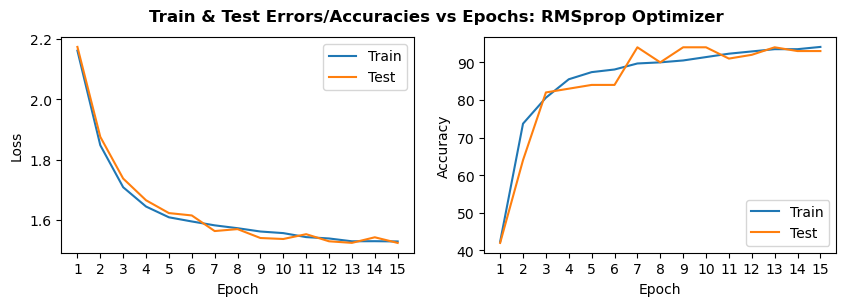

Final testing accuracy: 93.0% for dropout rate 0.5

--------------------------------------
Running model with dropout rate 0.8...


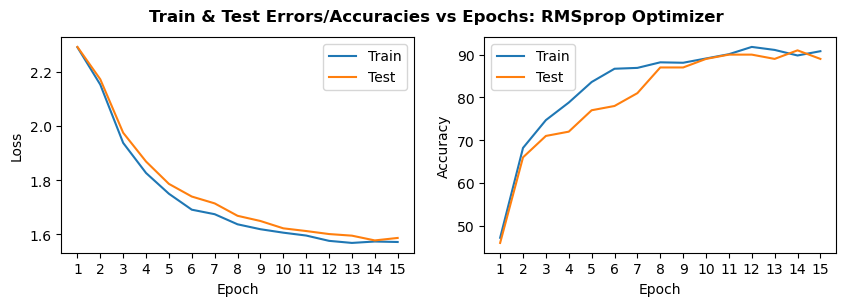

Final testing accuracy: 89.0% for dropout rate 0.8



In [21]:
test_dropout_rates = [0.2, 0.5, 0.8]

for p in test_dropout_rates:
    # Create the CNN model with dropout mlp model
    dropout_mlp_model = CNN()
    dropout_mlp_model.mlp = nn.Sequential(
        nn.Linear(in_features=4*7*7, out_features=49),
        nn.ReLU(),
        nn.Dropout(p=p), # Added dropout layer to hidden layer
        nn.Linear(in_features=49, out_features=10),
        nn.Softmax(dim=1)
    )
    dropout_mlp_model.to(device)
    
    # RMSProp optimizer
    optimizer = torch.optim.RMSprop(dropout_mlp_model.parameters(), lr=0.001, alpha=0.9)
    
    # Train the model
    print('--------------------------------------')
    print(f'Running model with dropout rate {p}...')
    final_accuracy = fit(train_dataloader, test_dataloader, dropout_mlp_model, loss_fn, optimizer, num_epochs, device, verbose=0, plot_errors=True)
    print(f'Final testing accuracy: {final_accuracy:.1f}% for dropout rate {p}\n')


We see that the testing accuracies slightly dropped as the drop out rate increased. This is might be because the model is not complex enough to overfit the training data, and hence dropout is not required, or since we are running the model for only 15 epochs. Also, the training and testing accuracies are very close, which shows that the model is not overfitting.

### 6) Using Batch Normalization

--------------------------------------
Running model with batch normalization...


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  1 -> Train Loss: 1.902962 | Test Loss: 1.944033 | Train Accuracy: 81.2% | Test Accuracy: 73.0%
Epoch  2 -> Train Loss: 1.677227 | Test Loss: 1.735745 | Train Accuracy: 90.8% | Test Accuracy: 89.0%
Epoch  3 -> Train Loss: 1.584190 | Test Loss: 1.627381 | Train Accuracy: 94.8% | Test Accuracy: 93.0%
Epoch  4 -> Train Loss: 1.555898 | Test Loss: 1.613343 | Train Accuracy: 95.6% | Test Accuracy: 90.0%
Epoch  5 -> Train Loss: 1.537092 | Test Loss: 1.580166 | Train Accuracy: 96.4% | Test Accuracy: 92.0%
Epoch  6 -> Train Loss: 1.512348 | Test Loss: 1.568027 | Train Accuracy: 97.5% | Test Accuracy: 91.0%
Epoch  7 -> Train Loss: 1.506608 | Test Loss: 1.536885 | Train Accuracy: 97.3% | Test Accuracy: 97.0%
Epoch  8 -> Train Loss: 1.491860 | Test Loss: 1.525038 | Train Accuracy: 98.1% | Test Accuracy: 96.0%
Epoch  9 -> Train Loss: 1.484246 | Test Loss: 1.524974 | Train Accuracy: 98.7% | Test Accuracy: 95.0%
Epoch 10 -> Train Loss: 1.481552 | Test Loss: 1.534933 | Train Accuracy: 98.7% | T

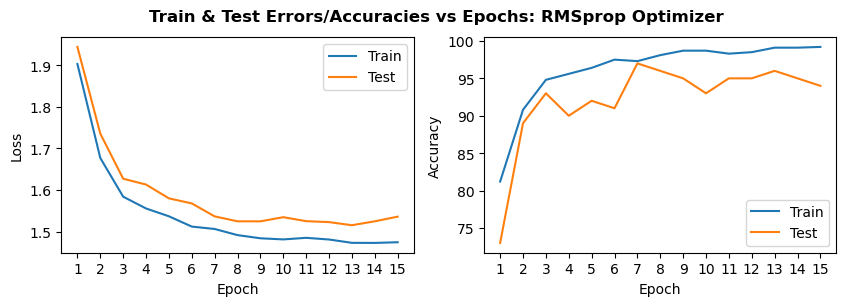

Final testing accuracy: 94.0% for batch normalization

--------------------------------------
Running model with dropout rate 0.2 and batch normalization...


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  1 -> Train Loss: 1.989925 | Test Loss: 2.021728 | Train Accuracy: 72.6% | Test Accuracy: 70.0%
Epoch  2 -> Train Loss: 1.842694 | Test Loss: 1.873290 | Train Accuracy: 82.8% | Test Accuracy: 72.0%
Epoch  3 -> Train Loss: 1.701271 | Test Loss: 1.766928 | Train Accuracy: 89.9% | Test Accuracy: 81.0%
Epoch  4 -> Train Loss: 1.631452 | Test Loss: 1.686443 | Train Accuracy: 92.2% | Test Accuracy: 86.0%
Epoch  5 -> Train Loss: 1.579700 | Test Loss: 1.613126 | Train Accuracy: 92.9% | Test Accuracy: 95.0%
Epoch  6 -> Train Loss: 1.559699 | Test Loss: 1.604316 | Train Accuracy: 95.3% | Test Accuracy: 93.0%
Epoch  7 -> Train Loss: 1.537555 | Test Loss: 1.568704 | Train Accuracy: 95.2% | Test Accuracy: 94.0%
Epoch  8 -> Train Loss: 1.524715 | Test Loss: 1.553564 | Train Accuracy: 95.7% | Test Accuracy: 96.0%
Epoch  9 -> Train Loss: 1.515585 | Test Loss: 1.540424 | Train Accuracy: 96.3% | Test Accuracy: 95.0%
Epoch 10 -> Train Loss: 1.525162 | Test Loss: 1.560536 | Train Accuracy: 96.4% | T

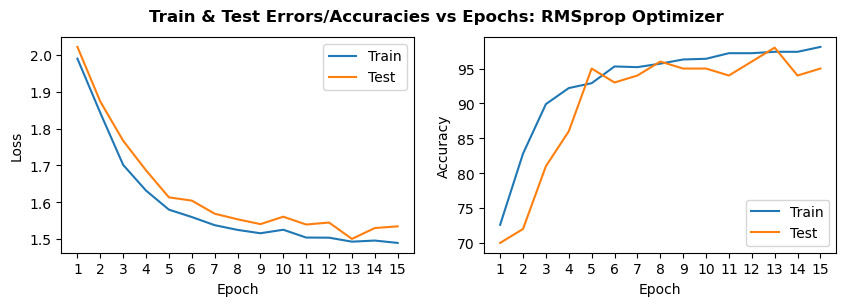

Final testing accuracy: 95.0% for dropout rate 0.2 and batch normalization



In [22]:
p = 0.2 # Dropout rate

# CNN model with batch normalization
bn_model = CNN()
bn_model.mlp = nn.Sequential(
    nn.Linear(in_features=4*7*7, out_features=49),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=49), # Added batch normalization layer
    nn.Linear(in_features=49, out_features=10),
    nn.Softmax(dim=1)
)
bn_model.to(device)
optimizer = torch.optim.RMSprop(bn_model.parameters(), lr=0.001, alpha=0.9)

# Train the model
print('--------------------------------------')
print(f'Running model with batch normalization...')
final_accuracy = fit(train_dataloader, test_dataloader, bn_model, loss_fn, optimizer, num_epochs, device, verbose=2, plot_errors=True)
print(f'Final testing accuracy: {final_accuracy:.1f}% for batch normalization\n')

# CNN model with both dropout and batch normalization
dropout_bn_model = CNN()
dropout_bn_model.mlp = nn.Sequential(
    nn.Linear(in_features=4*7*7, out_features=49),
    nn.ReLU(),
    nn.Dropout(p=p), # Added dropout layer to hidden layer
    nn.BatchNorm1d(num_features=49), # Added batch normalization layer
    nn.Linear(in_features=49, out_features=10),
    nn.Softmax(dim=1)
)
dropout_bn_model.to(device)
optimizer = torch.optim.RMSprop(dropout_bn_model.parameters(), lr=0.001, alpha=0.9)

# Train the model
print('--------------------------------------')
print(f'Running model with dropout rate {p} and batch normalization...')
final_accuracy = fit(train_dataloader, test_dataloader, dropout_bn_model, loss_fn, optimizer, num_epochs, device, verbose=2, plot_errors=True)
print(f'Final testing accuracy: {final_accuracy:.1f}% for dropout rate {p} and batch normalization\n')

Hence we can see that batch normalization helps the model get very high training accuracies as well as converge very quickly, but without drop outs, it overfits the data and is not able to generalize well. However, when using both batch normalization and dropouts, we get a very good model which generalizes very well too